# Load libraries

In [1]:
!pip install numdifftools

In [1]:
from __future__ import print_function, division

import itertools
import time

import torch as th
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sympy import *
import pathlib
import pdb
import matplotlib.pyplot as plt
import sys

In [8]:
sys.path.append('..')
from third_party.classification import *
from ConformalizedES.method import CES_regression
from ConformalizedES.networks import mse_model, MSE_loss
from ConformalizedES.inference import Conformal_PI
from third_party.coverage import *

# Define useful functions

In [10]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

In [20]:
class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=False):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()


# Generate the data

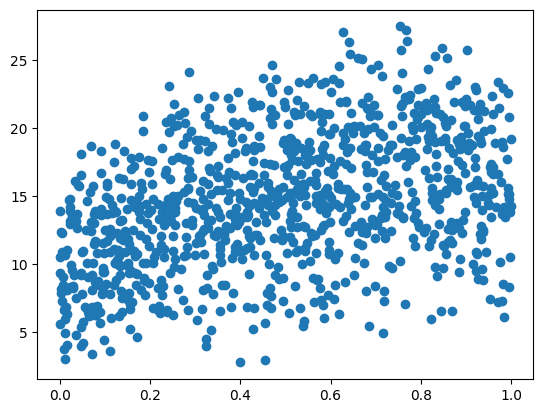

In [35]:
from sklearn.datasets import make_friedman1

n_samples = 1000
n_features = 100

X, y = make_friedman1(n_samples=n_samples, n_features=n_features, noise=0.0, random_state=None)

plt.scatter(X[:,0], y)
plt.show()

# Benchmark method

In [55]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 200
n_val = 50
n_cal = 10
n_test = 100 
method_ = 'Benchmark'

seed = 2322
np.random.seed(seed)
th.manual_seed(seed)

# split the data into proper training, validation, and calibration set, set test data aside 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
idx_test = np.random.permutation(n_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

idx = np.random.permutation(n_train+n_val+n_cal)
idx_train_BM, idx_val_BM, idx_cal_BM = idx[:n_train], idx[n_train:n_val+n_train], idx[n_val+n_train: n_val+n_train + n_cal]
X_train_BM, y_train_BM = X_train[idx_train_BM], y_train[idx_train_BM]
X_val_BM, y_val_BM = X_train[idx_val_BM], y_train[idx_val_BM]
X_cal_BM, y_cal_BM = X_train[idx_cal_BM], y_train[idx_cal_BM]

print("Size (BM): train (%d, %d), validation (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM.shape[0], X_train_BM.shape[1], 
       X_val_BM.shape[0], X_val_BM.shape[1], 
       X_cal_BM.shape[0], X_cal_BM.shape[1], 
       X_test.shape[0], X_test.shape[1]))

Size (BM): train (200, 100), validation (50, 100), calibration (10, 100), test (100, 100)


In [43]:
# set the hyperparameters
batch_size = 16
dropout = 0
num_epochs = 200
lr = 0.005
wd = 1e-5

In [44]:
train_loader = DataLoader(PrepareData(X_train_BM, y_train_BM, scale_X=False), batch_size=batch_size)
val_loader = DataLoader(PrepareData(X_val_BM, y_val_BM, scale_X=False), batch_size=batch_size, drop_last = True) 
calib_loader = DataLoader(PrepareData(X_cal_BM, y_cal_BM, scale_X=False), batch_size=1, shuffle = False, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)


# intialize the model
in_shape = X_train_BM.shape[1]
hidden_layer_size = 128

# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [45]:
# initialization
BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=val_loader, criterion= MSE_loss,
                        optimizer=optimizer, verbose = False)

In [46]:
# Train the model and save snapshots 
save_every = 1    # Save model after every few epoches
BM_reg.full_train(save_dir = './content', save_every = save_every)

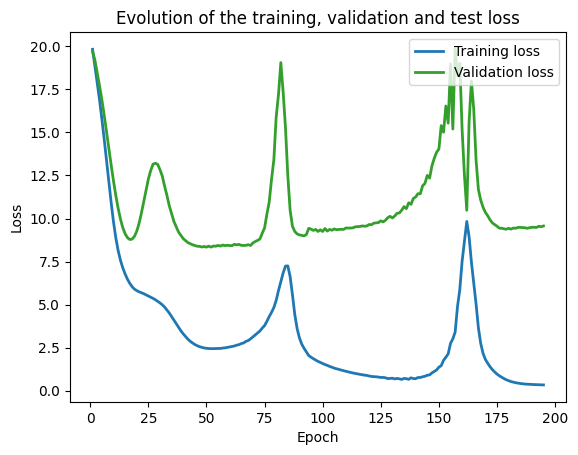

In [47]:
plot_loss(BM_reg.train_loss_history[5:], BM_reg.val_loss_history[5:])

In [48]:
# compute validation loss (burn-out first 20 epochs)
val_loss = np.mean(BM_reg.val_loss_history[-20:])

In [49]:
# Check the best models
bm_loss, bm_model, loss_history = BM_reg.select_model()

In [50]:
# Split conformal prediction 
alpha = 0.1

# store coverage indicator for every test sample
coverage_BM = []
# store size of the prediction interval 
size_BM = []
# store test loss
test_losses_BM = []
# store prediction intervals for every test sample
pi_BM = []

# initialize
C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find prediction interval
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model)
  pi_BM.append(benchmarkPI)
  # find size and coverage indicator
  size_BM.append(benchmarkPI[0]._measure)
  coverage_BM.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  ## load the best model
  BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=val_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  BM_reg.net.load_state_dict(torch.load(bm_model, map_location=device))
  ## compute loss on test samples
  test_loss = BM_reg.get_loss(input, response)
  test_losses_BM.append(test_loss)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.16it/s]


In [51]:
# store conditional coverage
wsc_coverages_BM = []

# compute conditional coverage
for i in tqdm(np.arange(10)):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM, M=100, delta = 0.1)
  wsc_coverages_BM.append(wsc_coverage)

In [53]:
print("The marginal coverage rate is (BM) {}".format(sum(coverage_BM)/len(coverage_BM)))
print("The conditional coverage rate is (BM) {}".format(sum(wsc_coverages_BM)/len(wsc_coverages_BM)))
print("The average size is (BM) {}".format(sum(size_BM)/len(size_BM)))
print("The test loss is (BM) {}".format(sum(test_losses_BM)/len(test_losses_BM)))
print("The validation loss is (BM) {}".format(val_loss))

The marginal coverage rate is (BM) 0.89
The conditional coverage rate is (BM) 0.9141258741258742
The average size is (BM) 9.66615677833557
The test loss is (BM) 9.953337669372559
The validation loss is (BM) 9.46341907978058


# The benchmark method ignoring exchangeability

In [56]:
# specify the number of samples in training, validation, calibration and test datasets
method_ = 'Benchmark_noexc'

seed = 2322
np.random.seed(seed)
th.manual_seed(seed)

# split the data into proper training, validation, and calibration set, set test data aside 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
idx_test = np.random.permutation(n_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

idx = np.random.permutation(n_train+n_val+n_cal)
idx_train_BM_noexc, idx_cal_BM_noexc = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]
X_train_BM_noexc, y_train_BM_noexc = X_train[idx_train_BM_noexc], y_train[idx_train_BM_noexc]
X_cal_BM_noexc, y_cal_BM_noexc = X_train[idx_cal_BM_noexc], y_train[idx_cal_BM_noexc]

print("Size (BM_noexc): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM_noexc.shape[0], X_train_BM_noexc.shape[1], 
       X_cal_BM_noexc.shape[0], X_cal_BM_noexc.shape[1], 
       X_test.shape[0], X_test.shape[1]))


Size (BM_noexc): train (250, 100), calibration (10, 100), test (100, 100)


In [57]:
# set the hyperparameters
batch_size = 16
dropout = 0
num_epochs = 200
lr = 0.005
wd = 1e-5

In [58]:
train_loader = DataLoader(PrepareData(X_train_BM_noexc, y_train_BM_noexc, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_BM_noexc, y_cal_BM_noexc, scale_X=False), batch_size=1, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

# intialize the model
in_shape = X_train_BM_noexc.shape[1]
hidden_layer_size = 128

# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [59]:
# intiialization
BM_reg_noexc = CES_regression(mod, 
                              device, 
                              train_loader, 
                              batch_size=batch_size, 
                              max_epoch = num_epochs, 
                              learning_rate=lr, 
                              # using calibration set to choose the best model
                              val_loader=calib_loader, 
                              criterion= MSE_loss, 
                              optimizer=optimizer, 
                              verbose = False)

In [60]:
# Train the model and save snapshots 
save_every = 1    # Save model after every few epoches
BM_reg_noexc.full_train(save_dir = './content', save_every = save_every)

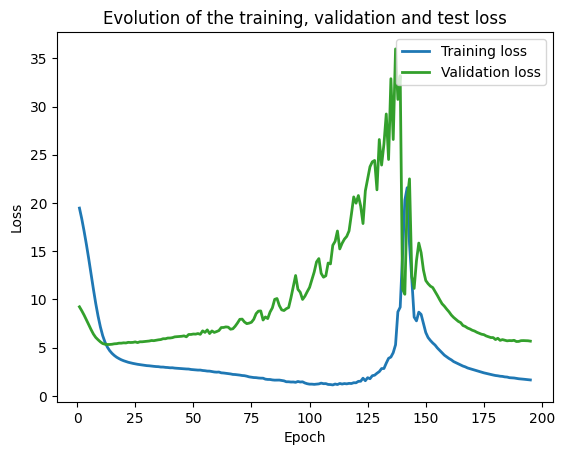

In [61]:
plot_loss(BM_reg_noexc.train_loss_history[5:], BM_reg_noexc.val_loss_history[5:])

In [62]:
# compute validation loss (burn-out first 20 epochs)
val_loss = np.mean(BM_reg_noexc.val_loss_history[-20:])

In [63]:
# Check the best models
# using calibration set to choose the best model
bm_loss_noexc, bm_model_noexc, loss_history_noexc = BM_reg_noexc.select_model()

In [64]:
# Split conformal prediction 
alpha = 0.1

# store coverage indicator for every test sample
coverage_BM_noexc = []
# store size of the prediction interval 
size_BM_noexc = []
# store test loss
test_losses_BM_noexc = []
# store prediction intervals for every test sample
pi_BM_noexc = []

# initialize
C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find prediction interval
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model_noexc)
  pi_BM_noexc.append(benchmarkPI)
  # find size and coverage indicator
  size_BM_noexc.append(benchmarkPI[0]._measure)
  coverage_BM_noexc.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  ## load the best model
  BM_reg_noexc_temp = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=calib_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)  
  BM_reg_noexc_temp.net.load_state_dict(torch.load(bm_model_noexc, map_location=device))
  ## compute loss on test samples
  test_loss = BM_reg_noexc_temp.get_loss(input, response)
  test_losses_BM_noexc.append(test_loss)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.11it/s]


In [65]:
wsc_coverages_BM_noexc = []

for i in tqdm(np.arange(10)):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM_noexc, M=100, delta = 0.1)
  wsc_coverages_BM_noexc.append(wsc_coverage)

100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


In [66]:
print("The marginal coverage rate is (BM no exc) {}".format(sum(coverage_BM_noexc)/len(coverage_BM_noexc)))
print("The conditional coverage rate is (BM no exc) {}".format(np.nanmean(wsc_coverages_BM_noexc)))
print("The average size is (BM no exc) {}".format(sum(size_BM_noexc)/len(size_BM_noexc)))
print("The test loss is (BM no exc) {}".format(sum(test_losses_BM_noexc)/len(test_losses_BM_noexc)))
print("The validation loss is (BM no exc) {}".format(val_loss)) 

The marginal coverage rate is (BM no exc) 0.69
The conditional coverage rate is (BM no exc) 0.7903896103896104
The average size is (BM no exc) 7.22362516403198
The test loss is (BM no exc) 10.601493835449219
The validation loss is (BM no exc) 5.82511555481702
